# Trabalho de IA: MLP

Integrantes:
- Ana Clara das Neves Barreto - 13672540
- Eloisa Antero Guisse - 13781924
- Marcos Martins de Oliveira Pacheco - 13672602
- Jamyle Gonçalves Rodrigues Silva - 13672338
- Lucca Pinto -
- Sarah Klock Mauricio - 13673131

Divas pop q nao tem hit solo ha 50 anos:
- Lady Gaga
- Katy Perry
- Demi Lovato
- Selena Gomez
- Jessie J

## Desenvolvimento do modelo

Importações

In [27]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
from graphviz import Digraph
import json
import openpyxl

Funções que lidam com a conversão entre letras e vetores de binários

In [28]:
alfabeto = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

def letra_para_vetor(letra):
    """
    Transforma um caractere num vetor de 26 posições, no qual a posição da letra correspondente é 1 e o restante é -1.
    :param letra: Letra a ser transformada num vetor
    :return: Vetor binário de 26 posições
    """
    vetor = [-1] * 26
    pos_letra = alfabeto.index(letra)
    vetor[pos_letra] = 1

    return vetor

def vetor_para_letra(vetor):
    """
    Encontra a letra do alfabeto correspondente a um vetor de 26 posições.
    :param vetor: Vetor de 26 posições que representa uma letra do alfabeto.
    :return: Letra correspondente.
    """
    # Encontra a posição do maior valor no vetor
    maior_pos = np.argmax(vetor)

    # Encontra a letra correspondente no alfabeto
    letra = alfabeto[maior_pos]

    return letra

Funções para leituras de arquivos

In [29]:
def ler_arq_imagens(nome_arq):
    """
    Lê o arquivo de imagens e retorna um array numpy.

    Args:
        nome_arq (str): Caminho para o arquivo de imagens.

    Returns:
        np.ndarray: Array numpy contendo as imagens.
    """
    with open(nome_arq, 'r') as file:
        data = file.read().strip().split('\n')
    data = [list(map(int, filter(lambda x: x.strip(), line.split(',')))) for line in data if line.strip()]
    return np.array(data)

def ler_arq_classes(nome_arq):
    """
    Lê o arquivo de classes e retorna um array numpy.

    Args:
        nome_arq (str): Caminho para o arquivo de classes.

    Returns:
        np.ndarray: Array numpy contendo as classes.
    """
    with open(nome_arq, 'r') as file:
        data = []
        for line in file:
            vetor_letra = letra_para_vetor(line[0])
            data.append(vetor_letra)
    return np.array(data)

Funções para a divisão dos dados

In [30]:
def shuffle_dados(dados, classes):
    """
        Embaralha os dados de um vetor mantendo as respectivas classificações na mesma ordem.

        Args:
            entrada (np.array): Vetor dos dados a serem divididos.
            classes (np.array): Classificação dos dados a serem dividos.

        Returns:
            (np.array): Vetor de dados embaralhado.
            (np.array): Vetor de classificação dos dados da primeira parte da divisão.
        """
    indices = np.arange(dados.shape[0])
    np.random.shuffle(indices)
    return dados[indices], classes[indices]

def dividir_dados(entrada, classes, test_proportion=0.2):
    """
        Divide dois vetores de dados em uma determinada proporção (padrão: 80/20).

        Args:
            entrada (np.array): Vetor dos dados a serem divididos.
            classes (np.array): Classificação dos dados a serem dividos.
            div_proportion (float): Proporção da divisão dos dados (padrão: 20%)

        Returns:
            dados_primeira_parte (np.array): Vetor de dados da primeira parte da divisão.
            classes_primeira_parte (np.array): Vetor de classificação dos dados da primeira parte da divisão.
            dados_segunda_parte (np.array): Vetor de dados da segunda parte da divisão.
            classes_segunda_parte (np.array): Vetor de classificação dos dados da segunda parte da divisão.
        """
    # Transforma os vetores das classes nas letras correspondentes
    classes_letras = []
    for elemento in classes:
        classes_letras.append(vetor_para_letra(elemento))

    classes_letras = np.array(classes_letras)

    # Conta o número de classes
    classes_unicas, num_classes = np.unique(classes_letras, return_counts=True)
    
    # Calcula a quantidade desejada de cada classe no primeiro conjunto
    num_inst_classes = (num_classes * (1 - test_proportion)).astype(int)
    
    # Inicializa os vetores para as duas partes
    dados_primeira_parte = []
    classes_primeira_parte = []
    dados_segunda_parte = []
    classes_segunda_parte = []
    
    for classe, num_inst_classes in zip(classes_unicas, num_inst_classes):
        # Índices das amostras da classe atual
        indices_classe = np.where(classes_letras == classe)[0]

        # Seleciona aleatoriamente as amostras para o primeiro conjunto
        selected_indices = np.random.choice(indices_classe, size=num_inst_classes, replace=False)
        
        # Divide os dados e classes
        dados_primeira_parte.append(entrada[selected_indices])
        classes_primeira_parte.append(classes[selected_indices])
        
        # As amostras restantes vão para o segundo conjunto
        remaining_indices = np.setdiff1d(indices_classe, selected_indices)
        dados_segunda_parte.append(entrada[remaining_indices])
        classes_segunda_parte.append(classes[remaining_indices])
    
    # Concatena os vetores
    dados_primeira_parte = np.concatenate(dados_primeira_parte)
    classes_primeira_parte = np.concatenate(classes_primeira_parte)
    dados_segunda_parte = np.concatenate(dados_segunda_parte)
    classes_segunda_parte = np.concatenate(classes_segunda_parte)

    dados_primeira_parte, classes_primeira_parte = shuffle_dados(dados_primeira_parte, classes_primeira_parte)
    dados_segunda_parte, classes_segunda_parte = shuffle_dados(dados_segunda_parte, classes_segunda_parte)

    return dados_primeira_parte, classes_primeira_parte, dados_segunda_parte, classes_segunda_parte


Funcao pra reconstruir imagens a partir do array de array


In [31]:
def reconstruct_image(row_index, image_array):
    """
    Reconstrói e plota uma imagem a partir do array numpy.

    Args:
        row_index (int): Índice da linha da imagem a ser reconstruída.
        image_array (np.ndarray): Array numpy contendo as imagens.
    """
    image_array = image_array[row_index]
    image_reshaped = np.reshape(image_array, (10, 12))

    plt.figure(figsize=(4, 3))
    plt.imshow(image_reshaped, cmap='gray')
    plt.colorbar()
    plt.show()

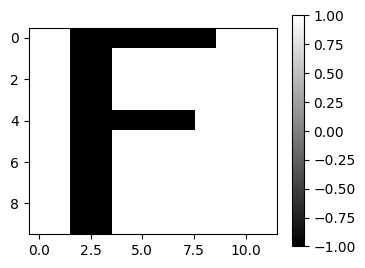

In [33]:
image = ler_arq_imagens('X.txt')
reconstruct_image(5,image)

Função para matriz de confusão

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plotar_matriz_de_confusao(predictions, y_test):
    """
    Traduz os dados dos arrays predictions e y_test para outros dois arrays
    apenas contendo as letras previstas e originais de teste e plota uma matriz
    de confusão usando o sklearn.metrics

    Args:
        predictions: Array contendo os resultados previstos pelo MLP.
        y_test: Array contendo os dados de teste do MLP
    """
    
    # Listas que irão conter as letras previstas e de teste
    predictions_letras = []
    y_test_letras = []

    # Converter os arrays de predictions e y_test para letras
    i = 0
    for i in range(len(predictions)):
        letra = vetor_para_letra(predictions[i])
        predictions_letras.append(letra)
    
    j = 0
    for j in range(len(predictions)):    
       letra = vetor_para_letra(y_test[j])
       y_test_letras.append(letra)

    # Array com todas as possibilidades, ou seja, o alfabeto de 'A' a 'Z'
    classes = [chr(i) for i in range(65, 91)] 
        
    cm = confusion_matrix(y_test_letras, predictions_letras, labels= classes)

    # Plot usando ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix using ConfusionMatrixDisplay')
    plt.show()


Funções de ativação

In [38]:
def sigmoid(x, der=False):
    if der:
        fx = sigmoid(x)
        return fx * (1 - fx)
    return 1.0 / (1.0 + np.exp(-x))

def tanh(x, der=False):
    if der:
        return 1 - np.tanh(x) ** 2
    return np.tanh(x)

def relu(x, der=False):
    if der:
        return np.where(x > 0, 1, 0)
    return np.maximum(0, x)

def leaky_relu(x, der=False):
    alpha = 0.01
    if der:
        return np.where(x > 0, 1, alpha)
    return np.where(x > 0, x, alpha * x)

def soft_max(x, der=False):
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x)

def activation_function(x, func, der=False):
    return func(x, der)

activation_functions1_names = ["sigmoid", "tanh", "relu", "leaky_relu"]
activation_functions2_names = ["tanh", "leaky_relu"]
activation_functions = {"sigmoid": sigmoid, 
                        "tanh": tanh, 
                        "relu": relu, 
                        "leaky_relu": leaky_relu
                        }

Função para inicialização de pesos

In [39]:
def init_xavier(n_in, n_out):
    """
    Inicializa os pesos com a inicialização Xavier.

    Args:
        n_in (int): Número de unidades na camada de entrada (ou unidades na camada anterior).
        n_out (int): Número de unidades na camada de saída.

    Returns:
        (numpy.ndarray): Uma matriz de pesos inicializados.
    """
    stddev = np.sqrt(2.0 / (n_in + n_out))
    return np.random.randn(n_in, n_out) * stddev

Classes da MLP (e início efetivo da codificação da rede neural)

In [40]:
class Layer:
    def __init__(self, input_size, output_size, learning_rate, act_fun, output_layer=False, momentum=0):
        """
        Inicializa uma nova camada na rede neural.

        Args:
            input_size (int): Número de neurônios na camada anterior ou tamanho dos dados de entrada.
            output_size (int): Número de neurônios na camada atual.
            learning_rate (float): Taxa de aprendizado usada para ajustar os pesos e biases durante o treinamento.
            act_fun (function): Função de ativação da camada.
            output_layer (bool): Booleano que indica se a camada é a de saída da MLP ou não.

        Attributes:
            weights (np.array): Matriz de pesos, onde cada peso conecta um neurônio de entrada a um neurônio de saída.
            biases (np.array): Vetor de biases, um para cada neurônio de saída.
            weighted_input (np.array): Armazena a entrada ponderada (antes da aplicação de qualquer função de ativação).
            output_data (np.array): Armazena a saída da camada, que neste caso é simplesmente a entrada ponderada.
            input_data (np.array): Armazena a entrada da camada antes da ponderação.
        """
        self.input_size = input_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.act_fun = act_fun
        self.output_layer = output_layer
        self.momentum = momentum
        self.weights = init_xavier(input_size, output_size) 
        self.biases = np.random.randn(1, output_size)
        self.previous_weight_delta = np.zeros((input_size, output_size))
        self.weighted_input = None
        self.output_data = None
        self.input_data = None

    def forward(self, input_data):
        """
        Realiza o feed forward da camada.

        :param input_data: Vetor de dados de entrada.
        :return: Saída após multiplicação pelos pesos e função de ativação.
        """
        self.input_data = input_data
        self.weighted_input = np.dot(input_data, self.weights) + self.biases
        self.output_data = activation_function(self.weighted_input, self.act_fun)

        return self.output_data

    def backward(self, error):
        """
        Realiza o backward propagation da camada.

        :param error: Erros que serão usados para calcular a correção dos pesos.
        :return: Gradientes para serem usados na correção da camada abaixo.
        """
        # Caso não seja a camada de saída, multiplica o erro pela derivada da função de ativação sobre a entrada ponderada da camada.
        if not self.output_layer:
            error = error * activation_function(self.weighted_input, self.act_fun, True)

        if self.input_data.ndim == 1:
            self.input_data = self.input_data.reshape(1, -1)  # Garante que input_data é bidimensional
        if error.ndim == 1:
            error = error.reshape(1, -1)  # Garante que error é bidimensional

        # Calcula correções e gradientes
        input_error = np.dot(error, self.weights.T)
        weights_error = np.dot(self.input_data.T, error) * self.learning_rate + self.momentum * self.previous_weight_delta
        self.previous_weight_delta = weights_error

        # Atualiza pesos e biases
        self.weights += weights_error
        self.biases += self.learning_rate * np.sum(error, axis=0, keepdims=True)
        return input_error

In [42]:
class NeuralNetwork:
    def __init__(self, learning_rate, neurons_n=120, activation_func1=sigmoid, activation_func2=leaky_relu):
        """
        Inicializa a rede neural com camadas especificadas.

        Args:
            learning_rate (float): Taxa de aprendizado usada para ajustar os pesos e biases durante o treinamento.

        Attributes:
            learning_rate (float): Taxa de aprendizado da rede neural.
            hidden_layer1 (Layer): Primeira camada oculta da rede neural.
            output_layer (Layer): Camada de saída da rede neural.
            final_output (np.array): Armazena a saída final da rede após a propagação direta.
        """
        self.learning_rate = learning_rate
        self.hidden_layer1 = Layer(120, neurons_n, self.learning_rate, activation_func1, momentum=0.8)
        self.output_layer = Layer(neurons_n, 26, self.learning_rate, activation_func2, True, momentum=0.8)
        self.final_output = None

    def forward_propagation(self, input_data):
        """
        Realiza a propagação para frente através de toda a rede.

        Args:
            input_data (np.array): Dados de entrada para a rede.

        Returns:
            np.array: Saída final da rede.
        """
        output = self.hidden_layer1.forward(input_data)
        self.final_output = self.output_layer.forward(output)
        return self.final_output

    def back_propagation(self, output_error):
        """
        Realiza a propagação para trás através de toda a rede.

        Args:
            output_error (np.array): Erro na saída da rede.
        """
        error = self.output_layer.backward(output_error)
        self.hidden_layer1.backward(error)

In [54]:
class MultilayerPerceptron:
    def __init__(self, early_stop_param=0, learning_rate=0, min_training_error=0, max_epochs_num=0, neurons_n=120, activation_func1=sigmoid, activation_func2=leaky_relu, print_mlp=True):
        """
        Inicializa os parâmetros para o treinamento da rede neural.

        Args:
            learning_rate (float): Taxa de aprendizado do modelo.
            early_stop_param (int): Número de épocas sem diminuição de erro permitido pelo earlystop.
            min_training_error_error (float): Erro mínimo desejado para o treinamento.
            max_epochs_num (int): Número máximo de épocas para o treinamento.

        Attributes:
            learning_rate (float): Taxa de aprendizado do modelo.
            early_stop_param (int): Número de épocas sem diminuição de erro permitido pelo earlystop.
            min_training_error_error (float): Erro mínimo desejado para o treinamento.
            max_epochs_num (int): Número máximo de épocas para o treinamento.
            min_error (float): Menor erro de validação encontrado.
            negative_error_var_num (int): Contador de épocas com aumento do erro.
            current_epoch_error (float): Taxa de erro da época atual.
            last_epoch_error (float): Taxa de erro da última época.
            neural_network (NeuralNetwork): Rede neural do modelo.
        """
        self.learning_rate = learning_rate
        self.early_stop_param = early_stop_param
        self.min_training_error = min_training_error
        self.max_epochs_num = max_epochs_num
        self.min_error = 1
        self.negative_error_var_num = 0
        self.current_epoch_error = 0
        self.last_epoch_error = 0
        self.print_mlp = print_mlp

        # Lista para armazenar os erros de treinamento em cada época
        self.training_errors = []

        # Lista para armazenar os erros de validação em cada época (em caso de earlystop)
        self.validation_errors = []

        # Inicializa a rede neural
        self.neural_network = NeuralNetwork(learning_rate=learning_rate, neurons_n=neurons_n, activation_func1=activation_func1, activation_func2=activation_func2)
        
    def train(self, entrada, classes, earlystop=False):
        """
        Treina a rede neural usando o conjunto de dados de treinamento.

        Args:
            entrada (np.array): Dados de entrada para treinamento.
            classes (np.array): Labels correspondentes para o treinamento.
            earlystop (boolean): Booleano que indica se earlystop será usado ou não
        """
        # Treina a rede com earlystop caso o parâmetro seja verdadeiro
        if earlystop: 

            # Divide os dados de entrada num conjunto de treinamento e outro de validação
            x_train, y_train, x_val, y_val = dividir_dados(entrada, classes)

            # Cria uma variável que irá armazenar a rede neural com o menor erro encontrado
            best_neural_network = copy.deepcopy(self.neural_network)
            
            # Treina a MLP
            for epoch in range(self.max_epochs_num):
                epoch_error = 0
                # Embaralha a entrada
                x_train, y_train = shuffle_dados(x_train, y_train)
                
                # Loop que treina a MLP com os dados de treinamento
                for x, y in zip(x_train, y_train):
                    # Realiza o feed forward
                    output = self.neural_network.forward_propagation(x)

                    # Calcula o erro de saída
                    output_error = y - output

                    # Realiza o back propagation
                    self.neural_network.back_propagation(output_error)

                    # Calcula o erro quadrático médio e soma ao erro médio da época
                    epoch_error += np.mean((np.power(output_error, 2))/2)

                # Armazena erro de treinamento médio
                train_error = epoch_error / x_train.shape[0]

                # Calcula a acurácia e erro de validação do modelo
                acuracia, val_error, dp_erro = self.get_accuracy(x_val, y_val)
                
                # Armazena os erros nos vetores de erros
                self.training_errors.append(train_error)
                self.validation_errors.append(val_error)

                # Printa erro e acurácia a cada dez épocas
                if self.print_mlp and epoch % 10 == 0:
                    print(
                        f"Época {epoch}/{self.max_epochs_num}, Acurácia: {acuracia:.5f}, Erro de validação: {val_error:.5f}, Erro de treino: {train_error:.5f}")
                
                # Verifica parâmetros de earlystop
                if train_error < self.min_training_error:
                    print("Erro mínimo atingido. Parando o treinamento.")
                    break
                
                # Verifica se foi encontrado um erro menor que o mínimo registrado
                if val_error <= self.min_error:

                    # Atualiza menor erro encontrado
                    self.min_error = val_error

                    # Zera o contador de aumento de erro
                    self.negative_error_var_num = 0

                    # Salva a rede neural que obteve o menor erro
                    best_neural_network = copy.deepcopy(self.neural_network)

                # Se não, aumenta o contador de épocas sem diminuição do erro
                else:
                    self.negative_error_var_num += 1

                if self.negative_error_var_num >= self.early_stop_param:
                    print("Parando antecipadamente devido ao aumento do erro de validação.")
                    # Restaura o melhor conjunto de pesos encontrado
                    self.neural_network = copy.deepcopy(best_neural_network)
                    break
        
        # Treina a rede sem earlystop
        else:
            # Treina a MLP
            for epoch in range(self.max_epochs_num):
                epoch_error = 0

                # Loop que treina a MLP com os dados passados como parâmetro
                for x, y in zip(entrada, classes):
                    # Realiza o feed forward
                    output = self.neural_network.forward_propagation(x)

                    # Calcula o erro de saída
                    output_error = y - output

                    # Realiza o back propagation
                    self.neural_network.back_propagation(output_error)

                    # Calcula o erro quadrático médio e soma ao erro médio da época
                    epoch_error += np.mean((np.power(output_error, 2))/2)

                # Armazena erro de treinamento médio
                train_error = epoch_error / entrada.shape[0]
                
                # Armazena os erros nos vetores de erros
                self.training_errors.append(train_error)

                # Printa erro e acurácia a cada dez épocas
                if self.print_mlp and epoch % 10 == 0:
                    print(
                        f"Época {epoch}/{self.max_epochs_num}, Erro de treino: {train_error:.5f}")

    def get_accuracy(self, entrada, saida_esperada):
        """
        Obtém a acurácia e erro médio da MLP.

        Args:
            entrada (np.array): Dados de entrada para teste.
            saida_esperada (np.array): Saída esperada da rede neural.

        Returns:
            acuracia (float): Porcentagem de acertos da rede.
            erro_medio (float): Erro médio.
            erro_dp (float): Desvio padrão do erro.
        """

        # Inicializa variáveis para calcular acurácia
        num_testes = 0
        num_acertos = 0
        erros = []

        # Realiza teste para cada um dos dados de entrada
        for x, y in zip(entrada, saida_esperada):
            num_testes += 1
            
            # Realiza a predição
            predicao = self.neural_network.forward_propagation(x)

            # Calcula erro
            output_error = y - predicao
            erros.append(np.mean((np.power(output_error, 2) / 2)))

            # Obtém a letra predita pelo modelo
            letra_predita = vetor_para_letra(predicao)

            # Obtém a letra esperada
            letra_real = vetor_para_letra(y)

            if letra_predita == letra_real:
                num_acertos += 1

        
        acuracia = num_acertos / num_testes
        erro_medio = np.mean(erros)
        erro_dp = np.std(erros)

        return acuracia, erro_medio, erro_dp

    def predict(self, entrada):
        """
        Realiza predições usando a rede neural treinada.

        Args:
            entrada (np.array): Dados de entrada para teste.
            neural_network (NeuralNetwork): Instância da rede neural treinada.

        Returns:
            np.array: Predições da rede neural.
        """
        predictions = []
        for x in entrada:
            output = self.neural_network.forward_propagation(x)
            output = vetor_para_letra(output)
            output = letra_para_vetor(output)
            predictions.append(output)
        return np.array(predictions)
    
    def save_mlp(self, nome_arq, x_test, y_test):
        """
        Armazena os pesos das camadas e os erros médios de cada época num arquivo.

        Args:
            nome_arq (string): Nome do arquivo que irá armazenar os valores.
        """ 

        network = { 
            # Conversão dos pesos da primeira camada oculta para uma lista
            'hidden_layer1': {'weights': self.neural_network.hidden_layer1.weights.tolist(),
                            'biases': self.neural_network.hidden_layer1.biases.tolist()},

            # Conversão dos pesos da camada de saída para uma lista
            'output_layer': {'weights': self.neural_network.output_layer.weights.tolist(),
                            'biases': self.neural_network.output_layer.biases.tolist()},
            
            'train_errors' : self.training_errors,
            'val_errors' : self.validation_errors,
            'x_test': x_test.tolist(),
            'y_test': y_test.tolist()
        }

        # Abertura do arquivo para escrita
        with open(nome_arq, 'w') as f:
            # Salvando o dicionário no formato JSON
            json.dump(network, f) 

    def build_mlp(self, nome_arq):
        """
        Constrói a MLP a partir de um arquivo de pesos.

        Args:
            nome_arq (string): Nome do arquivo com os pesos e biases de cada camada.
        """
        with open(nome_arq, 'r') as f:
            network = json.load(f)

        self.neural_network.hidden_layer1.weights = np.array(network['hidden_layer1']['weights'])
        self.neural_network.hidden_layer1.biases = np.array(network['hidden_layer1']['biases'])
        self.neural_network.output_layer.weights = np.array(network['output_layer']['weights'])
        self.neural_network.output_layer.biases = np.array(network['output_layer']['biases'])

        self.training_errors = network['train_errors']
        self.validation_errors = network['val_errors']

        return np.array(network['x_test']), np.array(network['y_test'])

Lista de parâmetros para testar

MLP PADRÃO:
- Mostrar funcionamento da MLP e divisão do conjunto de dados
    - Mostra o que é exibido no terminal durante o treinamento 
        - Erro a cada 10 épocas
        - Erro médio e acurácia do modelo ao final do treinamento
    - Motra que os dados foram dividios na proporção 80/20, aleatoriamente, e com a distribuição uniforme de classes

- Teste de funções de ativação diferentes
    - Exibe gráfico de erro para cada função de ativação diferente
    - Acurácia final do modelo para cada função de ativação diferente
- Teste de learning rate, números de neruônios diferentes e inicialização com Xavier
    - Exibe gráfico de erro para cada learning rate e número de neurônios diferentes
    - Exibe acurácia para cada teste diferente
    - Após definidos learning rate e número de neurônios, exibe gráfico de erro e acurácia antes e depois do Xavier
Lista de parâmetros para testar

EARLYSTOP
- Mostrar gráfico de erro (médio e de validação) e matriz de confusão do modelo final escolhido com erro de validação agora
- Variar o parâmetro 'early_stop_param' e mostrar gráficos dos erros e matriz de confusão

CROSS VALIDATION
- Mostra gráficos de erro, acurácia e erro médio para cada fold
- Teste cross validation
    USANDO EARLYSTOP
    - Mostrar gráficos de erro (para erro de validação e erro médio) e matriz de confusão

Main: treina o modelo, printa a execução de cada época e depois obtém a acurácia e erro médio final.

Época 0/500, Acurácia: 0.33173, Erro de validação: 0.06857, Erro de treino: 0.08313
Época 10/500, Acurácia: 0.81250, Erro de validação: 0.02702, Erro de treino: 0.01979
Época 20/500, Acurácia: 0.83173, Erro de validação: 0.02133, Erro de treino: 0.01004
Época 30/500, Acurácia: 0.82692, Erro de validação: 0.01981, Erro de treino: 0.00571
Época 40/500, Acurácia: 0.85096, Erro de validação: 0.01846, Erro de treino: 0.00373
Época 50/500, Acurácia: 0.84615, Erro de validação: 0.01844, Erro de treino: 0.00250
Época 60/500, Acurácia: 0.84135, Erro de validação: 0.01805, Erro de treino: 0.00179
Época 70/500, Acurácia: 0.84615, Erro de validação: 0.01791, Erro de treino: 0.00130
Época 80/500, Acurácia: 0.84615, Erro de validação: 0.01815, Erro de treino: 0.00097
Época 90/500, Acurácia: 0.84135, Erro de validação: 0.01794, Erro de treino: 0.00076
Época 100/500, Acurácia: 0.84135, Erro de validação: 0.01788, Erro de treino: 0.00057
Época 110/500, Acurácia: 0.84615, Erro de validação: 0.01809, Err

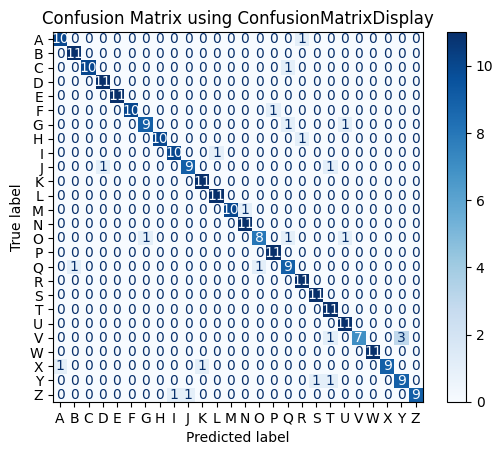

In [55]:
def main():
    # Lendo os arquivos
    imagens = ler_arq_imagens('X.txt')
    classes = ler_arq_classes('Y_letra.txt')

    # Dividindo os dados em conjuntos de treinamento e teste
    x_train, y_train, x_test, y_test = dividir_dados(imagens, classes, test_proportion=0.2)

    # Convertendo para float
    y_train = y_train.astype(float)
    y_test = y_test.astype(float)

    # Parâmetros para o treinamento
    early_stop_param = 50
    learning_rate = 0.001
    min_output_error = 0.0001
    max_epochs_num = 500

    # Inicializa o Multilayer Perceptron com os parâmetros de treinamento
    mlp = MultilayerPerceptron(early_stop_param, learning_rate, min_output_error, max_epochs_num, 50, sigmoid, tanh, True)

    # Treina a rede neural
    mlp.train(x_train, y_train, True)

    print("Treinamento concluído.")

    acuracia, erro, dp = mlp.get_accuracy(x_test, y_test)
    print(f"Acurácia do modelo: {acuracia}")
    print(f"Erro médio do modelo: {erro}")
    print(f"Desvio padrão do erro: {dp}")

    # Testa a rede neural
    predictions = mlp.predict(x_test)

    # Exibe algumas predições para verificação
    for i in range(20):
        predicao = vetor_para_letra(predictions[i])
        correto = vetor_para_letra(y_test[i])

        print(f"Predição: {predicao}, Real: {correto}")

    # Armazena MLP num arquivo
    mlp.save_mlp("mlp.txt", x_test, y_test)

    # Plota a matriz de confusão
    plotar_matriz_de_confusao(predictions, y_test)

main()

In [58]:
def grid_search():
    # Lendo os arquivos
    imagens = ler_arq_imagens('X.txt')
    classes = ler_arq_classes('Y_letra.txt')

    # Dividindo os dados em conjuntos de treinamento e teste
    x_train, y_train, x_test, y_test = dividir_dados(imagens, classes, test_proportion=0.1)

    # Convertendo para float
    y_train = y_train.astype(float)
    y_test = y_test.astype(float)

    # Parâmetros fixos para o treinamento
    early_stop_param = 500
    min_output_error = 0.000000001
    max_epochs_num = 500

    grid_results = {
        "Taxa de aprendizado": [],
        "Nº de neuronios camada escondida": [],
        "Função de ativação 1": [],
        "Função de ativação 2": [],
        "Acurácia": [],
        "Erro médio": [],
        "Desvio padrão de erro": [],
        "Erros de treinamento por época": [],
        "Erros de validação por época": []
    }
    
    learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
    neurons_n = 50
    af1 = "sigmoid"
    af2 = "tanh"

    for learning_rate in learning_rates:
        parameters = f"{learning_rate}, {neurons_n}, {af1}, {af2}"
        print(f"Busca por parametros:", parameters)

        activation_func1 = activation_functions[af1]
        activation_func2 = activation_functions[af2]

        # Inicializa o Multilayer Perceptron com os parâmetros de treinamento
        mlp = MultilayerPerceptron(early_stop_param, learning_rate, min_output_error, max_epochs_num, neurons_n, activation_func1, activation_func2, print_mlp=True)

        # Treina a rede neural
        mlp.train(x_train, y_train, True)

        print("Treinamento concluído.")

        acuracia, erro, dp = mlp.get_accuracy(x_test, y_test)
        print(f"Acurácia, erro médio e desvio padrão do erro: {acuracia}, {erro}, {dp}")
        
        grid_results["Taxa de aprendizado"].append(learning_rate)
        grid_results["Nº de neuronios camada escondida"].append(neurons_n)
        grid_results["Função de ativação 1"].append(af1)
        grid_results["Função de ativação 2"].append(af2)
        grid_results["Acurácia"].append(acuracia)
        grid_results["Erro médio"].append(erro)
        grid_results["Desvio padrão de erro"].append(dp)
        grid_results["Erros de treinamento por época"].append(mlp.training_errors)
        grid_results["Erros de validação por época"].append(mlp.validation_errors)

    
    return grid_results

grid_search_results = grid_search()
pd.DataFrame(grid_search_results).to_csv('grid_search_results.csv', index=False)

Busca por parametros: 0.0001, 50, sigmoid, tanh
Época 0/500, Acurácia: 0.03419, Erro de validação: 0.07584, Erro de treino: 0.12932
Época 10/500, Acurácia: 0.46581, Erro de validação: 0.06736, Erro de treino: 0.06694
Época 20/500, Acurácia: 0.61966, Erro de validação: 0.05787, Erro de treino: 0.05619
Época 30/500, Acurácia: 0.70085, Erro de validação: 0.04944, Erro de treino: 0.04645
Época 40/500, Acurácia: 0.73932, Erro de validação: 0.04316, Erro de treino: 0.03904
Época 50/500, Acurácia: 0.76496, Erro de validação: 0.03858, Erro de treino: 0.03352
Época 60/500, Acurácia: 0.77778, Erro de validação: 0.03527, Erro de treino: 0.02917
Época 70/500, Acurácia: 0.77778, Erro de validação: 0.03261, Erro de treino: 0.02588
Época 80/500, Acurácia: 0.79487, Erro de validação: 0.03052, Erro de treino: 0.02314
Época 90/500, Acurácia: 0.80342, Erro de validação: 0.02887, Erro de treino: 0.02081
Época 100/500, Acurácia: 0.81197, Erro de validação: 0.02748, Erro de treino: 0.01898
Época 110/500, Ac

C:\Users\despinxz\AppData\Local\Temp\ipykernel_12776\3395274282.py:5: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


Época 70/500, Acurácia: 0.54701, Erro de validação: 0.05698, Erro de treino: 0.04700
Época 80/500, Acurácia: 0.54701, Erro de validação: 0.05700, Erro de treino: 0.04334
Época 90/500, Acurácia: 0.62821, Erro de validação: 0.05063, Erro de treino: 0.03869
Época 100/500, Acurácia: 0.59829, Erro de validação: 0.05362, Erro de treino: 0.03477
Época 110/500, Acurácia: 0.61966, Erro de validação: 0.05257, Erro de treino: 0.03927
Época 120/500, Acurácia: 0.61966, Erro de validação: 0.05249, Erro de treino: 0.03987
Época 130/500, Acurácia: 0.61966, Erro de validação: 0.04826, Erro de treino: 0.03156
Época 140/500, Acurácia: 0.60684, Erro de validação: 0.05341, Erro de treino: 0.03356
Época 150/500, Acurácia: 0.65812, Erro de validação: 0.04771, Erro de treino: 0.02765
Época 160/500, Acurácia: 0.68376, Erro de validação: 0.04589, Erro de treino: 0.02577
Época 170/500, Acurácia: 0.66667, Erro de validação: 0.04554, Erro de treino: 0.02259
Época 180/500, Acurácia: 0.69658, Erro de validação: 0.04

In [46]:
def calcular_recall_multiclasse(y_true, y_pred, classes):
        """
        Calcula o recall para múltiplas classes.

        Args:
            y_true (list or np.array): Lista ou array com as classes verdadeiras.
            y_pred (list or np.array): Lista ou array com as classes preditas.
            classes (list): Lista de todas as classes possíveis.

        Returns:
            dict: Dicionário contendo o recall por classe, macro recall, micro recall e recall ponderado.
        """
        # Inicializa dicionários para contar TP e FN
        verdadeiros_positivos = {classe: 0 for classe in classes}
        falsos_negativos = {classe: 0 for classe in classes}
        
        # Conta TP e FN para cada classe
        for yt, yp in zip(y_true, y_pred):
            yt = vetor_para_letra(yt)
            yp = vetor_para_letra(yp)
            
            if yt == yp:
                verdadeiros_positivos[yt] += 1
            else:
                falsos_negativos[yt] += 1
        
        # Calcula o recall para cada classe
        recall_por_classe = {}
        for classe in classes:
            tp = verdadeiros_positivos[classe]
            fn = falsos_negativos[classe]
            recall_por_classe[classe] = tp / (tp + fn) if (tp + fn) > 0 else 0.0

        # Calcula o macro recall
        recall_macro = sum(recall_por_classe.values()) / len(classes)
        
        # Calcula o micro recall
        total_tp = sum(verdadeiros_positivos.values())
        total_fn = sum(falsos_negativos.values())
        recall_micro = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0

        # Calcula o recall ponderado
        total_instances = len(y_true)
        recall_ponderado = sum((verdadeiros_positivos[classe] / total_instances) * recall_por_classe[classe] for classe in classes)

        return {
            'recall_por_classe': recall_por_classe,
            'recall_macro': recall_macro,
            'recall_micro': recall_micro,
            'recall_ponderado': recall_ponderado
        }

Teste e exemplo da função de reconstruir MLP a partir do arquivo de pesos.

{'recall_por_classe': {'A': 0.9090909090909091, 'B': 1.0, 'C': 0.9090909090909091, 'D': 1.0, 'E': 1.0, 'F': 0.9090909090909091, 'G': 0.8181818181818182, 'H': 0.9090909090909091, 'I': 0.9090909090909091, 'J': 0.8181818181818182, 'K': 1.0, 'L': 1.0, 'M': 0.9090909090909091, 'N': 1.0, 'O': 0.7272727272727273, 'P': 1.0, 'Q': 0.8181818181818182, 'R': 1.0, 'S': 1.0, 'T': 1.0, 'U': 1.0, 'V': 0.6363636363636364, 'W': 1.0, 'X': 0.8181818181818182, 'Y': 0.8181818181818182, 'Z': 0.8181818181818182}, 'recall_macro': 0.9125874125874126, 'recall_micro': 0.9125874125874126, 'recall_ponderado': 0.8426573426573427}
Acurácia do modelo: 0.9125874125874126
Erro médio do modelo: 0.45721521907699264
Desvio padrão do modelo: 0.03251166867392237


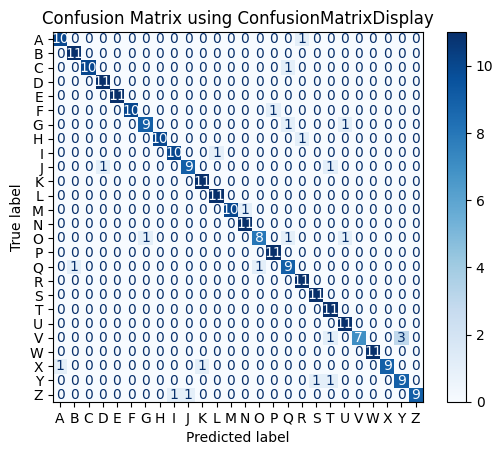

In [56]:
def teste_build_mlp():
    # Lendo os arquivos
    imagens = ler_arq_imagens('X.txt')
    classes = ler_arq_classes('Y_letra.txt')

    # Inicializa MLP sem nenhum parâmetro 
    mlp = MultilayerPerceptron()

    # Chama a função para construir os pesos a partir do arquivo
    x_test, y_test = mlp.build_mlp('mlp.txt')

    # Testa a rede neural
    predictions = mlp.predict(x_test)
    
    print(calcular_recall_multiclasse(y_test, predictions, alfabeto))

    acuracia, erro, dp = mlp.get_accuracy(x_test, y_test)
    print(f"Acurácia do modelo: {acuracia}")
    print(f"Erro médio do modelo: {erro}")
    print(f"Desvio padrão do modelo: {dp}")

    plotar_matriz_de_confusao(predictions, y_test)

teste_build_mlp()

Cross-validation

In [ ]:
def kfold(entrada, classes, num_particoes):
    """
    Divide os dados e classes em K partições para K-Fold Cross-Validation.

    Args:
        entrada (np.array): Vetor dos dados a serem divididos.
        classes (np.array): Vetor das classes dos dados.
        num_particoes (int): Número de partições (K).

    Returns:
        dados_particionados (list): Lista de K partições dos dados.
        classes_particionadas (list): Lista de K partições das classes.
    """
    # Transforma os vetores das classes nas letras correspondentes
    classes_letras = []
    for elemento in classes:
        classes_letras.append(vetor_para_letra(elemento))

    classes_letras = np.array(classes_letras)

    # Conta o número de classes e a quantidade de instâncias de cada uma delas no vetor de dados
    classes_unicas, num_classes = np.unique(classes_letras, return_counts=True)
    
    # Calcula a quantidade desejada de cada classe nos conjuntos
    num_inst_classes = (num_classes / num_particoes).astype(int)
    
    # Cria a lista de partições
    particoes = [[] for _ in range(num_particoes)]
    
    for classe, num_inst_classe in zip(classes_unicas, num_inst_classes):
        # Índices das amostras da classe atual
        indices = np.where(classes_letras == classe)[0]

        # Embaralha os índices
        np.random.shuffle(indices)

        # Adiciona o número de instâncias certo da classe em cada partição
        for i in range(num_particoes):
            if i != num_particoes - 1:
                particoes[i].extend(indices[(i * num_inst_classe) : ((i + 1) * num_inst_classe)])
            else:
                particoes[i].extend(indices[(i * num_inst_classe) :])
    
    dados_particionados = []
    classes_particionadas = []

    # Define os vetores de dados e classificação de cada partição
    for p in particoes:
        dados_particionados.append(entrada[p])
        classes_particionadas.append(classes[p])

    # Embaralha os dados de cada partição
    for i in range(num_particoes):
        dados_particionados[i], classes_particionadas[i] = shuffle_dados(dados_particionados[i], classes_particionadas[i])

    return dados_particionados, classes_particionadas

In [ ]:
# Teste função K-Fold
imagens = ler_arq_imagens('X.txt')
classes = ler_arq_classes('Y_letra.txt')

print(imagens.shape)
print(classes.shape)

imagens_part, classes_part = kfold(imagens, classes, 5)

for i in range(5):
    print(imagens_part[i].shape)
    print(classes_part[i].shape)
    classes_letras = []
    for elemento in classes_part[i]:
        classes_letras.append(vetor_para_letra(elemento))

    classes_letras = np.array(classes_letras)
    classes, num_classes = np.unique(classes_letras, return_counts=True)
    print(classes)
    print(num_classes)

(1326, 120)
(1326, 26)
(260, 120)
(260, 26)
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10]
(260, 120)
(260, 26)
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10]
(260, 120)
(260, 26)
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10]
(260, 120)
(260, 26)
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10]
(286, 120)
(286, 26)
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
[11 11 11 11 

In [ ]:
def train_cross_validation(entrada, classes, num_particoes):
    """
    Realiza o treinamento com cross validation de uma MLP.

    Args:
        entrada (np.array): Vetor dos dados de entrada.
        classes (np.array): Vetor das classes dos dados.
        num_particoes (int): Número de partições (K).
    """
    particoes_dados, particoes_classes = kfold(entrada, classes, num_particoes)

    early_stop_param = 50
    learning_rate = 0.1
    min_output_error = 0.01
    max_epochs_num = 500

    acuracia_total = 0

    for i in range(num_particoes):
        print(f"Treinamento K-Fold {i + 1}: ")

        # Define conjunto de testes
        dados_teste = particoes_dados[i]
        classes_teste = particoes_classes[i]

        # Remove conjunto de testes das partições
        min_output_error, max_epochs_num, early_stop_param, learning_rate
        dados_treinamento = [particao for j, particao in enumerate(particoes_dados) if j != i]
        dados_treinamento = np.concatenate(dados_treinamento)
        classes_treinamento = [particao for j, particao in enumerate(particoes_classes) if j != i]
        classes_treinamento = np.concatenate(classes_treinamento)

        # Inicializa o Multilayer Perceptron com os parâmetros de treinamento
        mlp = MultilayerPerceptron(early_stop_param, learning_rate, min_output_error, max_epochs_num)

        # Treina MLP
        mlp.train(dados_treinamento, classes_treinamento, earlystop=True)

        print(f"Treinamento {i + 1} finalizado.")
        acuracia, erro_medio, dp = mlp.get_accuracy(dados_teste, classes_teste)
        print(f"Acurácia: {acuracia:.2f}")
        print(f"Erro médio: {erro_medio:.2f}")
        print(f"Desvio padrão do erro: {dp:.2f}\n")

        acuracia_total += acuracia
    
    print("Cross-validation concluído.")
    print(f"Acurácia média: {acuracia_total / num_particoes:.2f}")

# Lendo os arquivos
imagens = ler_arq_imagens('X.txt')
classes = ler_arq_classes('Y_letra.txt')

# Convertendo para float
classes = classes.astype(float)

train_cross_validation(imagens, classes, 5)

Treinamento K-Fold 1: 
Época 0/500, Acurácia: 0.03846, Erro de validação: 0.07504, Erro de treino: 0.08455
Época 10/500, Acurácia: 0.76923, Erro de validação: 0.05258, Erro de treino: 0.05200
Época 20/500, Acurácia: 0.82906, Erro de validação: 0.05950, Erro de treino: 0.04827
Época 30/500, Acurácia: 0.84615, Erro de validação: 0.07132, Erro de treino: 0.05007
Época 40/500, Acurácia: 0.87179, Erro de validação: 0.08737, Erro de treino: 0.05498
Época 50/500, Acurácia: 0.87179, Erro de validação: 0.05098, Erro de treino: 0.05336
Época 60/500, Acurácia: 0.86325, Erro de validação: 0.07648, Erro de treino: 0.05336
Parando antecipadamente devido ao aumento do erro de validação.
Treinamento 1 finalizado.
Acurácia: 0.79
Erro médio: 0.05
Desvio padrão do erro: 0.01

Treinamento K-Fold 2: 
Época 0/500, Acurácia: 0.03846, Erro de validação: 0.07481, Erro de treino: 0.08466
Época 10/500, Acurácia: 0.75214, Erro de validação: 0.05408, Erro de treino: 0.05523
Época 20/500, Acurácia: 0.81197, Erro de

KeyboardInterrupt: 

## Exemplos de uso

In [ ]:
imagens = ler_arq_imagens('X.txt')
classes = ler_arq_classes('Y_letra.txt')
print(imagens.head())


AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [ ]:
print(classes.head())

In [ ]:
# Executando o treinamento e teste da rede neural
mlp = MultilayerPerceptron()
mlp.main(imagens, classes)#

In [ ]:
# Plotando o erro de treinamento
plt.plot(mlp.training_errors)
plt.title('Erro de Treinamento por Época')
plt.xlabel('Época')
plt.ylabel('Erro')
plt.grid(True)
plt.show()


In [ ]:
# Criação de uma tabela com os erros de treinamento
df_erros_treinamento = pd.DataFrame({
    'Época': range(len(mlp.training_errors)),
    'Erro': mlp.training_errors
})

# Exibindo a tabela
print(df_erros_treinamento)


Falta:

- fazer o erro parar de diminuir pouco
- tirar sklearn do cross-validation  --->  decidimos não tirar
- verificar se o gráfico tá gerando certo
- gerar matriz de confusão para testes da rede
